In [56]:
import pandas as pd
import numpy as np
import cupy as cp

import time

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss

import warnings
warnings.filterwarnings('ignore')

### Data

In [57]:
! ls data

processed.cleveland.data  titanic3.xls	titanic.csv  Titanic.csv


In [58]:
df = pd.read_excel("data/titanic3.xls")
df.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [59]:
# Drop some useless information
info_to_remove = ["name", "ticket", "cabin", "body", "boat"]
df = df.drop(columns=info_to_remove)

In [60]:
# One hot encoding
df["S_embarked"] = (df.embarked == "S")*1
df["C_embarked"] = (df.embarked == "C")*1
df["Q_embarked"] = (df.embarked == "Q")*1

df = df.drop(columns=["embarked"])

In [61]:
df["sex"] = df["sex"].apply(lambda x: 1 if x == "male" else 0)

In [62]:
# Replace NaNs in "home.dest"
df["home.dest"][df["home.dest"].isna()] = ["Other" for _ in range(df["home.dest"][df["home.dest"].isna()].shape[0])]
df["home.dest"] = df["home.dest"].apply(lambda x: x if df["home.dest"].value_counts()[x] > 1 else "Other" )

df["home.dest"].value_counts()

Other                               781
New York, NY                         64
London                               14
Montreal, PQ                         10
Paris, France                         9
                                   ... 
Spain / Havana, Cuba                  2
St Ives, Cornwall / Calumet, MI       2
London / Paris                        2
Elizabeth, NJ                         2
Co Athlone, Ireland New York, NY      2
Name: home.dest, Length: 153, dtype: int64

In [63]:
# Encoding with counts
df["home.dest_counts"] = df["home.dest"].apply(lambda x: df["home.dest"].value_counts()[x] / df.shape[0])
df = df.drop(columns=["home.dest"])

In [64]:
# Fill nans with mean values
df["age"][df["age"].isna()] = df["age"][~df["age"].isna()].mean()
df["fare"][df["fare"].isna()] = df["fare"][~df["fare"].isna()].mean()

In [65]:
df.head(3)

,pclass,survived,sex,age,sibsp,parch,fare,S_embarked,C_embarked,Q_embarked,home.dest_counts
0,1,1,0,29.0000,0,0,211.3375,1,0,0,0.003056
1,1,1,1,0.9167,1,2,151.5500,1,0,0,0.003056
2,1,0,0,2.0000,1,2,151.5500,1,0,0,0.003056


In [66]:
# Normalize
for column in ["pclass", "age", "parch", "fare"]:
    df[column] = df[column]/df[column].mean()

In [67]:
# Dublicate data
df1 = df.copy()

df2 = df.copy()
for i in range(10):
    df2 = pd.concat([df2, df], ignore_index=True)
    
df3 = df2.copy()
for i in range(10):
    df3 = pd.concat([df3, df2], ignore_index=True)
    
print("Data sizes: df1={}, df2={}, df3={}".format(df1.shape[0], df2.shape[0], df3.shape[0]))

Data sizes: df1=1309, df2=14399, df3=158389


In [68]:
dfs = [df1, df2, df3]

In [69]:
# Feature matrix and target
features_names = list(df.columns)
features_names.remove("survived")

X_ars = [np.array(df1[features_names]), np.array(df2[features_names]), np.array(df3[features_names])]
y_ars = [np.array(df1["survived"].values), np.array(df2["survived"].values), np.array(df3["survived"].values)]


## Experiments

In [70]:
accuracys, training_times = [{}, {}, {}], [{}, {}, {}]

### Sklearn

In [71]:
from sklearn.linear_model import LogisticRegression as LogisticRegression_sklearn

In [72]:
for i, (X_ar, y_ar) in enumerate(zip(X_ars, y_ars)):

    clf = LogisticRegression_sklearn(max_iter=50)

    start = time.time()
    clf.fit(X_ar, y_ar )
    training_times[i]["sklearn"] = time.time() - start 
    
    accuracys[i]["sklearn"] = clf.score(X_ar, y_ar)

### Numpy

In [73]:
from logistic_regression_numpy_cupy import LogisticRegression_py

In [74]:
for i, (X_ar, y_ar) in enumerate(zip(X_ars, y_ars)):

    clf = LogisticRegression_py(5, xp=np)

    start = time.time()
    clf.fit(X_ar, y_ar, num_itr=50, lr=1e-4)
    training_times[i]["numpy"] = time.time() - start 
    
    accuracys[i]["numpy"] = clf.score(X_ar, y_ar)

### Numpy loop

In [75]:
from logistic_regression_numpy_loop import forward_loop, score_loop

In [ ]:
for i, (X_ar, y_ar) in enumerate(zip(X_ars, y_ars)):

    start = time.time()
    W = forward_loop(X_ar, y_ar, lr=1e-6, show_train=True, num_itr=50)
    training_times[i]["numpy - loop"] = time.time() - start 
    
    accuracys[i]["numpy - loop"] = score_loop(X_ar, y_ar, W)

1 itr: loss=2.278029011203632, acc=0.4919786096256685
2 itr: loss=2.2691950839001125, acc=0.4919786096256685
3 itr: loss=2.2604734922060032, acc=0.4919786096256685
4 itr: loss=2.2518626646048263, acc=0.4919786096256685
5 itr: loss=2.2433610481350295, acc=0.4919786096256685
6 itr: loss=2.2349671083440303, acc=0.492742551566081
7 itr: loss=2.2266793292378373, acc=0.492742551566081
8 itr: loss=2.2184962132262314, acc=0.492742551566081
9 itr: loss=2.2104162810635803, acc=0.492742551566081
10 itr: loss=2.202438071784986, acc=0.492742551566081
11 itr: loss=2.1945601426378447, acc=0.492742551566081
12 itr: loss=2.1867810690088523, acc=0.492742551566081
13 itr: loss=2.1790994443462677, acc=0.492742551566081
14 itr: loss=2.1715138800775393, acc=0.492742551566081
15 itr: loss=2.1640230055222935, acc=0.492742551566081
16 itr: loss=2.1566254678007044, acc=0.492742551566081
17 itr: loss=2.149319931737207, acc=0.492742551566081
18 itr: loss=2.142105079759695, acc=0.492742551566081
19 itr: loss=2.134

### Cupy

In [78]:
for i, (X_ar, y_ar) in enumerate(zip(X_ars, y_ars)):

    clf = LogisticRegression_py(5, xp=cp)

    start = time.time()
    clf.fit(X_ar, y_ar, num_itr=50, lr=1e-4)
    training_times[i]["cupy"] = time.time() - start 
    
    accuracys[i]["cupy"] = clf.score(X_ar, y_ar)

### Torch - 1GPU

In [79]:
from logistic_regression_torch import LogisticRegression_torch, train_torch, score_torch

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [89]:
for i, (X_ar, y_ar) in enumerate(zip(X_ars, y_ars)):
    clf_torch = LogisticRegression_torch(num_features=X_ar.shape[1], 
                                     num_classes=5)
    clf_torch = clf_torch.to(device)

    criterion = BCEWithLogitsLoss()
    optimizer = SGD(clf_torch.parameters(), lr=1e-1)
    
    start = time.time()

    train_torch(clf_torch, criterion, optimizer, X_ar, y_ar, 
                num_itr=50, device=device)

    training_times[i]["torch - 1GPU"] = time.time() - start 
    
    accuracys[i]["torch - 1GPU"] = score_torch(clf_torch, X_ar, y_ar, device=device)

### Torch - 2GPU

In [176]:
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 2 GPUs!


In [91]:
for i, (X_ar, y_ar) in enumerate(zip(X_ars, y_ars)):
    
    clf_torch = LogisticRegression_torch(num_features=X_ar.shape[1], 
                                     num_classes=5)
    clf_torch = clf_torch.to(device)

    # Paralleling
    clf_torch_multi = nn.DataParallel(clf_torch)

    criterion = BCEWithLogitsLoss()
    optimizer = SGD(clf_torch_multi.parameters(), lr=1e-1)
    
    start = time.time()
    train_torch(clf_torch_multi, criterion, optimizer, X_ar, y_ar, 
                num_itr=50, device=device)
    training_times[i]["torch - 2GPU"] = time.time() - start 
    
    accuracys[i]["torch - 2GPU"] = score_torch(clf_torch, X_ar, y_ar, device=device)

In [92]:
accuracys

[{'sklearn': 0.7998472116119175,
  'numpy': 0.7708174178762414,
  'numpy - loop': 0.4919786096256685,
  'cupy': 0.7616501145912911,
  'torch - 1GPU': 0.6577540106951871,
  'torch - 2GPU': 0.6676852559205501},
 {'sklearn': 0.7983193277310925,
  'numpy': 0.6180290297937356,
  'numpy - loop': 0.5462184873949579,
  'cupy': 0.6180290297937356,
  'torch - 1GPU': 0.6699770817417876,
  'torch - 2GPU': 0.6440030557677616},
 {'sklearn': 0.7975553857906799,
  'numpy': 0.6180290297937356,
  'numpy - loop': 0.6180290297937356,
  'cupy': 0.6180290297937356,
  'torch - 1GPU': 0.6501145912910619,
  'torch - 2GPU': 0.6715049656226126}]

### Numba

In [93]:
from numba import jit, njit

In [97]:
forward_loop_jit = jit()(forward_loop)
score_loop_jit = jit()(score_loop)

In [98]:
for i, (X_ar, y_ar) in enumerate(zip(X_ars, y_ars)):

    start = time.time()
    W = forward_loop_jit(X_ar, y_ar, lr=1e-6, show_train=True, num_itr=50)
    training_times[i]["numba"] = time.time() - start 
    
    accuracys[i]["numba"] = score_loop(X_ar, y_ar, W)

1 itr: loss=2.370339960980894, acc=0.6180290297937356
2 itr: loss=2.3555153915722107, acc=0.6180290297937356
3 itr: loss=2.340899674991383, acc=0.6180290297937356
4 itr: loss=2.32649014429966, acc=0.6180290297937356
5 itr: loss=2.3122841607788986, acc=0.6180290297937356
6 itr: loss=2.298279113672246, acc=0.6180290297937356
7 itr: loss=2.284472419925526, acc=0.6180290297937356
8 itr: loss=2.2708615239297045, acc=0.6180290297937356
9 itr: loss=2.257443897264792, acc=0.6180290297937356
10 itr: loss=2.244217038445575, acc=0.6180290297937356
11 itr: loss=2.2311784726694843, acc=0.6180290297937356
12 itr: loss=2.2183257515670154, acc=0.6180290297937356
13 itr: loss=2.2056564529550333, acc=0.6180290297937356
14 itr: loss=2.1931681805932204, acc=0.6180290297937356
15 itr: loss=2.1808585639440987, acc=0.6172650878533231
16 itr: loss=2.168725257936698, acc=0.6172650878533231
17 itr: loss=2.1567659427344097, acc=0.6172650878533231
18 itr: loss=2.1449783235068227, acc=0.6172650878533231
19 itr: lo

49 itr: loss=1.2110110049969682, acc=0.6180290297937356
50 itr: loss=1.2106479542463695, acc=0.6180290297937356


## Vizualization

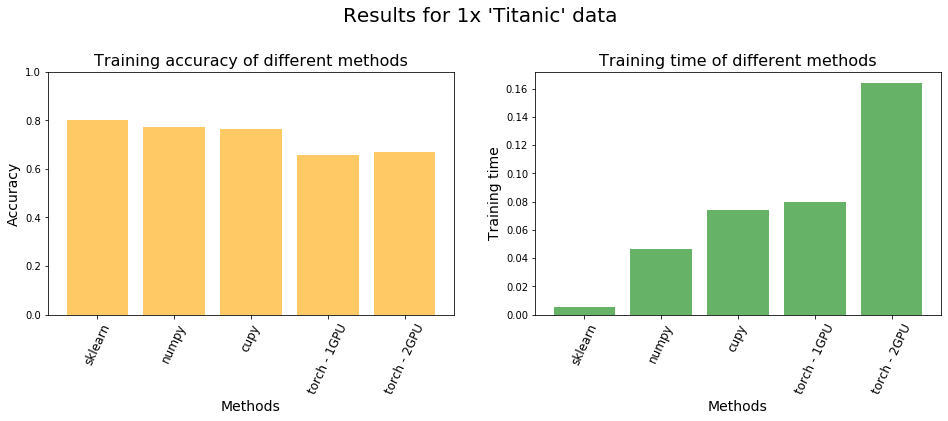

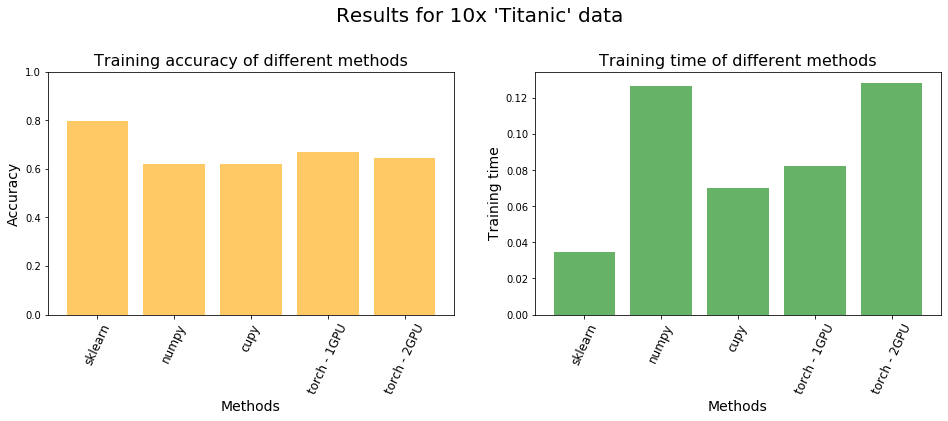

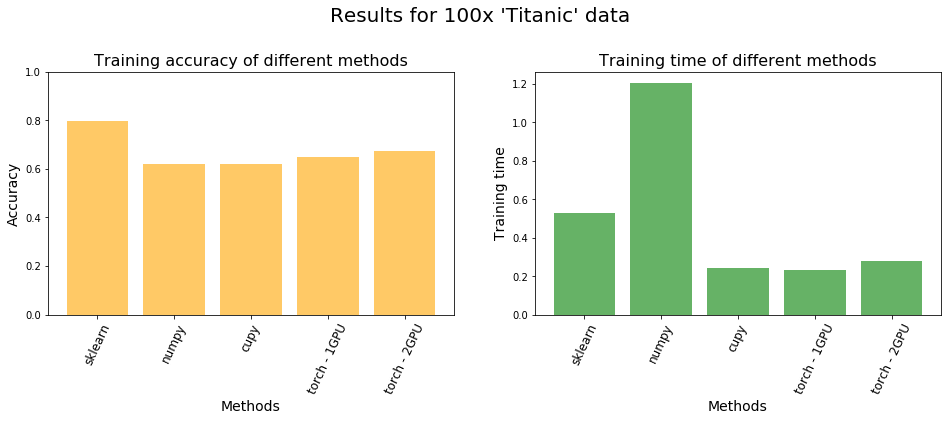

In [109]:
for j, times in enumerate(["1x", "10x", "100x"]):

    names = ['sklearn', 'numpy', 'cupy', 'torch - 1GPU', 'torch - 2GPU']

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    Y = [accuracys[j][name] for name in names]
    ax[0].bar(X, Y, alpha=0.6, color="orange")
    ax[0].set_ylim(0., 1.)

    Y = [training_times[j][name] for name in names]
    ax[1].bar(X, Y, alpha=0.6, color="green")

    ax[0].set_ylabel("Accuracy", fontsize=14)
    ax[1].set_ylabel("Training time", fontsize=14)

    for i in range(2):
        ax[i].set_xlabel("Methods", fontsize=14)
        ax[i].set_xticklabels(X, rotation=65, fontsize=12)

    ax[0].set_title("Training accuracy of different methods", fontsize=16)
    ax[1].set_title("Training time of different methods", fontsize=16)

    plt.suptitle("Results for {} 'Titanic' data".format(times), fontsize=20)
    plt.subplots_adjust(top=0.8)
    
    plt.show()